# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В датасете представлены исторические данные: технические характеристики, комплектации и цены автомобилей. Мне нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
#установка и проверка наличия обновлений библиотек
!pip install phik
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
#импорт библиотек
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import phik
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import xgboost as xg
import lightgbm as lgbm
import catboost as cb

In [3]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

## Подготовка данных

Загружаю данные.

In [4]:
data = pd.read_csv('/datasets/autos.csv')
data.info(memory_usage='deep')
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


У нас есть 7 численных признаков, включая целевой, и девять столбцов типа object, содержащих текстовую информацию либо даты.

### Обработка дубликатов и пропущенных значений.

Проверю датасет на наличие дубликатов.

In [5]:
data.duplicated().sum()

4

Дубликатов не так уж и много. Избавлюсь от них.

In [6]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

Теперь посмотрим, в каких столбцах у нас есть попущенные значения.

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Любопытно, что пропуски есть только в категориальных переменных. При этом наверняка сказать, какие значения в них пропущенны мы не можем, а потому я заменю пропуски на строку "unknown".

In [8]:
data = data.fillna('unknown')
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Пропуски успешно устранены.


### Борьба с аномалиями

Для начала, осмотрим численные данные через их распределение.

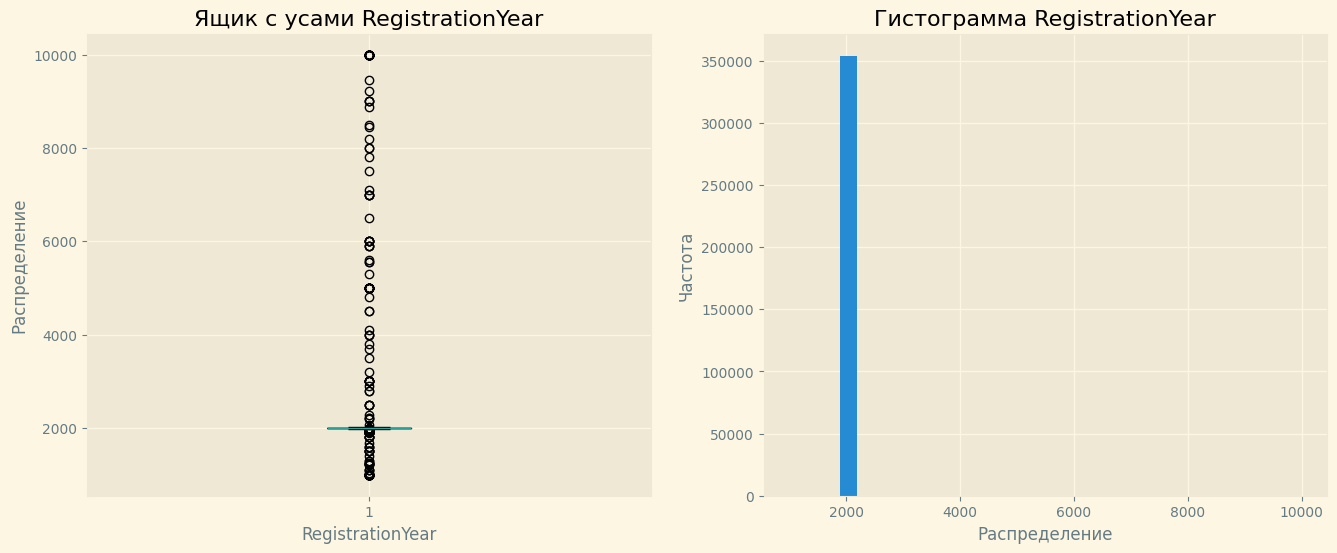

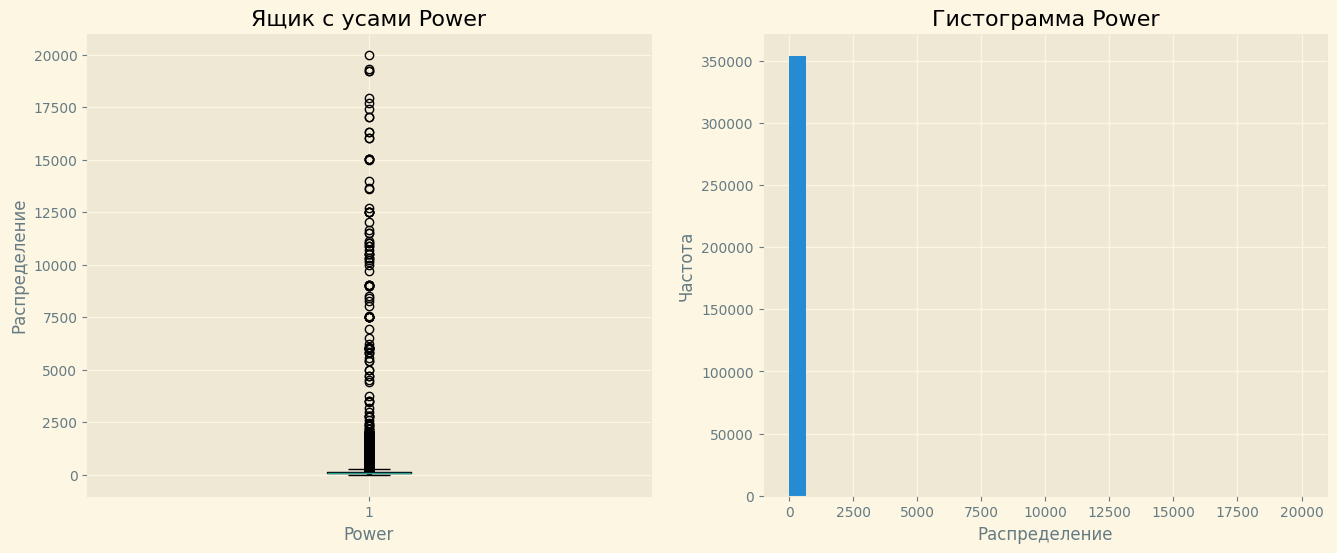

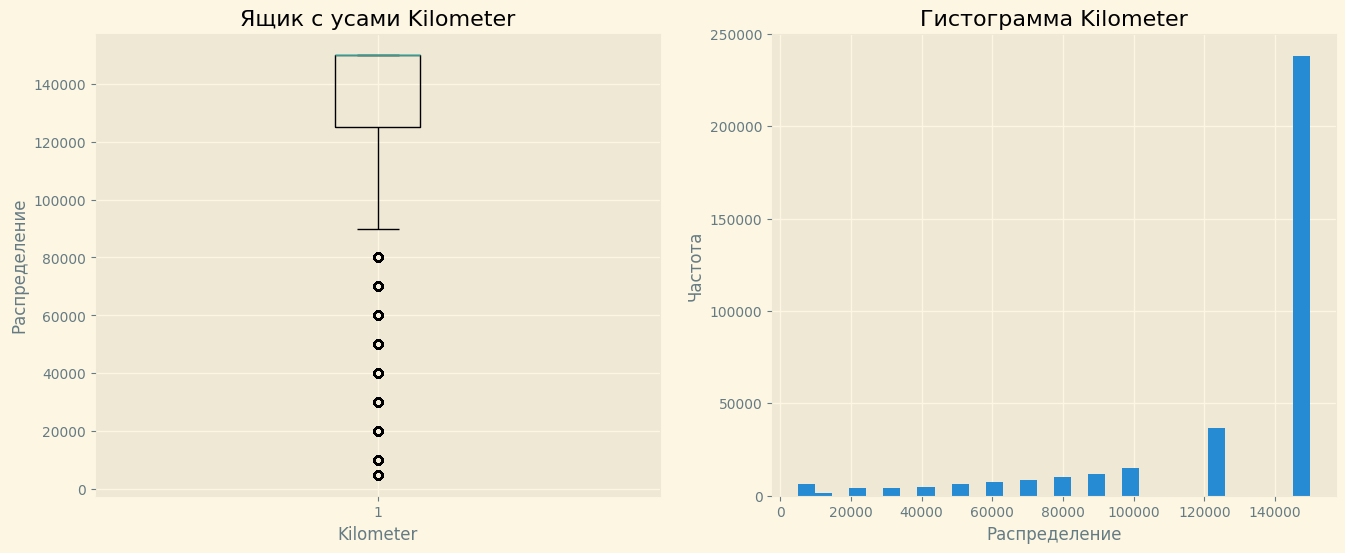

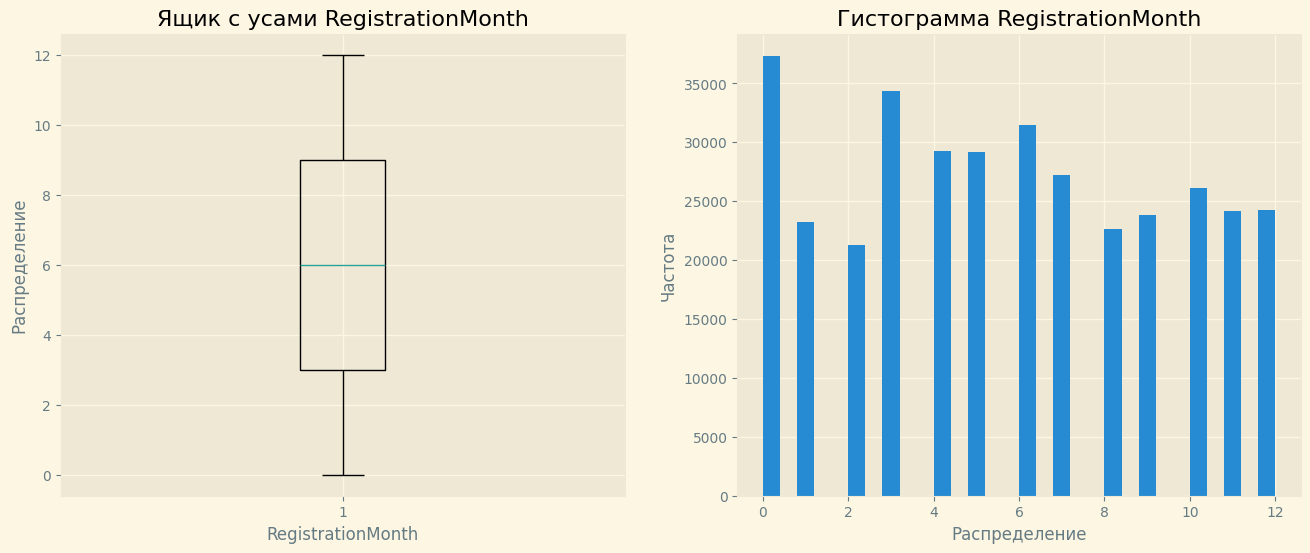

In [9]:
cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
for i in range(len(cols)):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].boxplot(data[cols[i]])
    axes[1].hist(data[cols[i]], bins=30)
    axes[0].set_title(f'Ящик с усами {cols[i]}')
    axes[1].set_title(f'Гистограмма {cols[i]}')
    axes[0].set_ylabel('Распределение')
    axes[1].set_ylabel('Частота')
    axes[0].set_xlabel(cols[i])
    axes[1].set_xlabel('Распределение')
    plt.show()

У пробега в километрах совсем немного выбросов, и возможность такого маленького пробега в любом случае не исключена: на вторичном рынке продаются и совсем новые машины.

А вот выбросы в годах регистрации и лошадиных силах определённо являются аномалиями. Ведь машина не может быть выпущена в 10,000 году и иметь 20,000 лошадиных сил. Подобные выбросы я исключу из датасета.

In [10]:
data = data.loc[data['RegistrationYear'] > 1960]
data = data.loc[data['RegistrationYear'] < 2023]

In [11]:
data = data.loc[data['Power'] > 50]
data = data.loc[data['Power'] < 400]

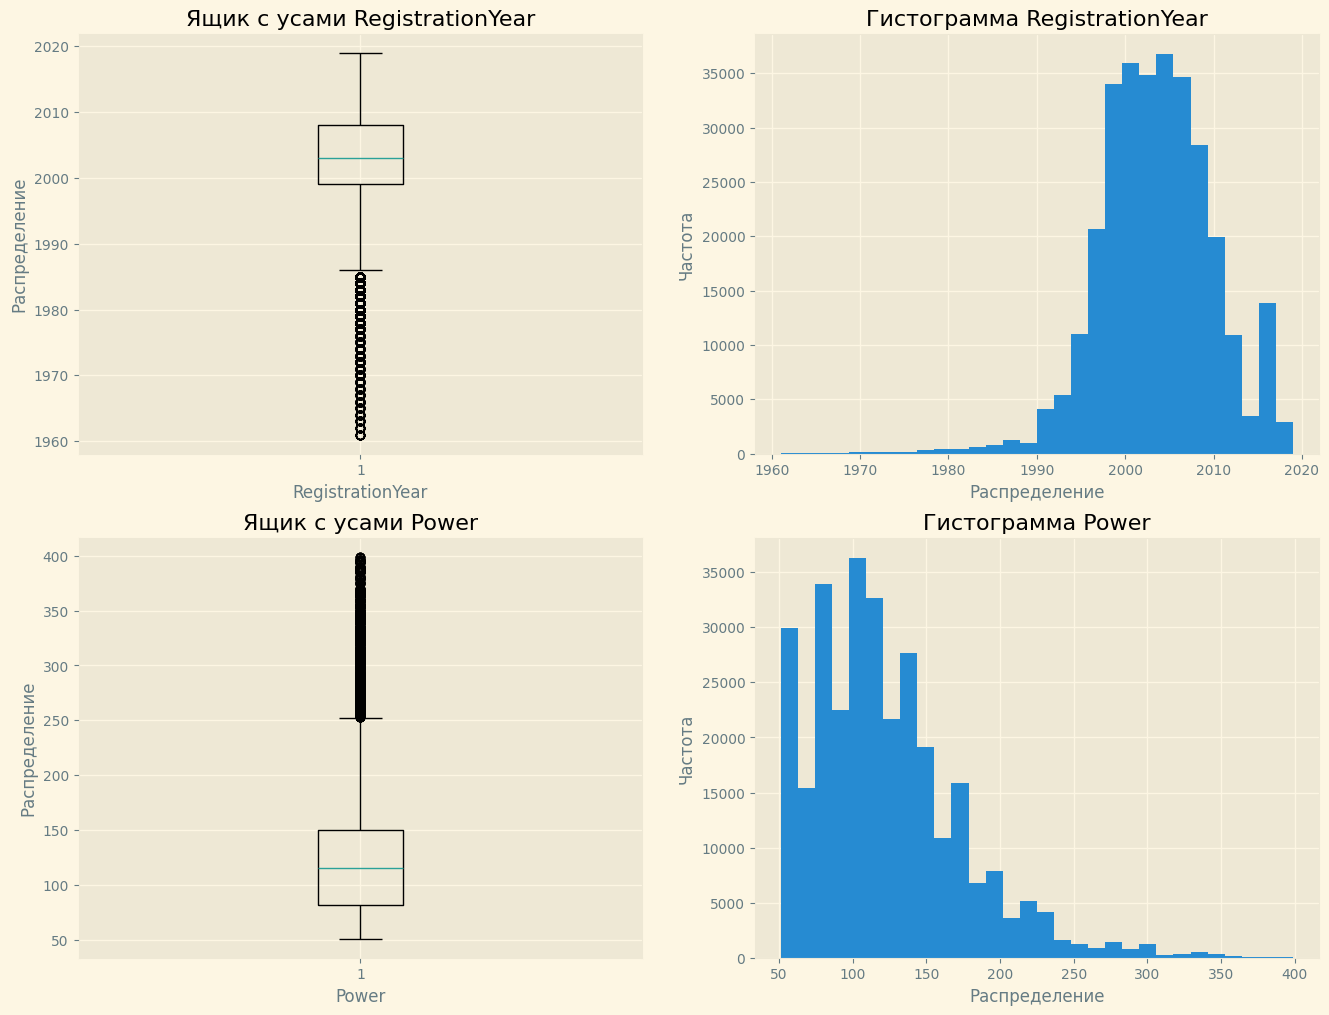

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes[0,0].boxplot(data['RegistrationYear'])
axes[0,0].set_ylabel('Распределение')
axes[0,0].set_xlabel('RegistrationYear')
axes[0,1].hist(data['RegistrationYear'], bins=30)
axes[0,1].set_ylabel('Частота')
axes[0,1].set_xlabel('Распределение')
axes[0,0].set_title('Ящик с усами RegistrationYear')
axes[0,1].set_title('Гистограмма RegistrationYear')
axes[1,0].boxplot(data['Power'])
axes[1,0].set_ylabel('Распределение')
axes[1,0].set_xlabel('Power')
axes[1,1].hist(data['Power'], bins=30)
axes[1,1].set_ylabel('Частота')
axes[1,1].set_xlabel('Распределение')
axes[1,0].set_title('Ящик с усами Power')
axes[1,1].set_title('Гистограмма Power')
plt.show()

У нас ещё остались выбросы в обоих столбцах, но это нормально: существуют автомобили, у которых высокая мощность двигателя, или которые очень раннего года производства, и их значительно меньше, чем обычных авто. Эти данные не выбиваются из здравого смысла.

Я удалила аномалии в годе регистрации, но есть также ещё одна информация в формате времени — дата выгрузки информации в базу данных. И то, и другое не может превышать 2023 год, иначе эти события произошли в будущем. И также, автомобиль не может быть зарегистрирован после выгрузки данных.

Переведу дату выгрузки из типа object в тип datetime.

In [13]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302649 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        302649 non-null  datetime64[ns]
 1   Price              302649 non-null  int64         
 2   VehicleType        302649 non-null  object        
 3   RegistrationYear   302649 non-null  int64         
 4   Gearbox            302649 non-null  object        
 5   Power              302649 non-null  int64         
 6   Model              302649 non-null  object        
 7   Kilometer          302649 non-null  int64         
 8   RegistrationMonth  302649 non-null  int64         
 9   FuelType           302649 non-null  object        
 10  Brand              302649 non-null  object        
 11  Repaired           302649 non-null  object        
 12  DateCreated        302649 non-null  object        
 13  NumberOfPictures   302649 non-null  int64   

Теперь, когда дата имеет формат даты, построим гистограмму распределения и посмотрим, превосходят ли объекты настоящее время.

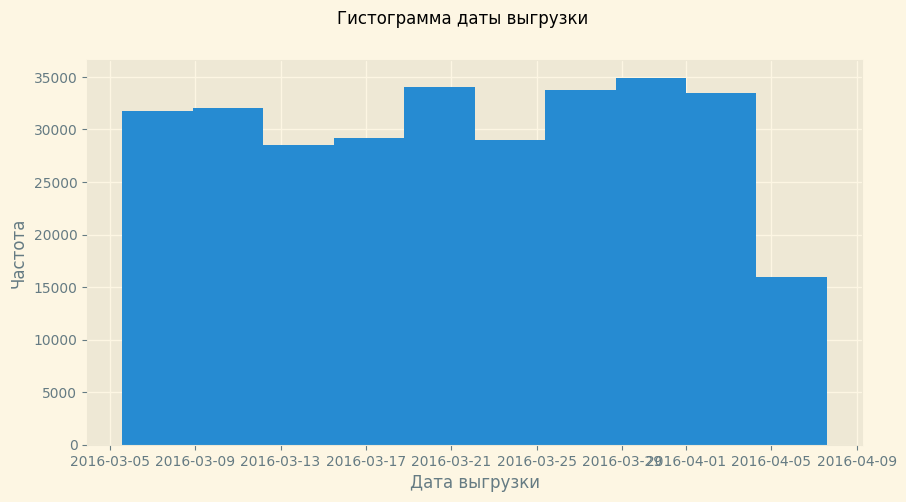

In [14]:
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(data['DateCrawled'])
fig.suptitle('Гистограмма даты выгрузки')
axes.set_ylabel('Частота')
axes.set_xlabel('Дата выгрузки')
plt.show()

Все объявления были выгружены в начале 2016. А это значит, автомобили, зарегистрированные в этом году и далее скорее всего являются аномалиями. Удаляю их.

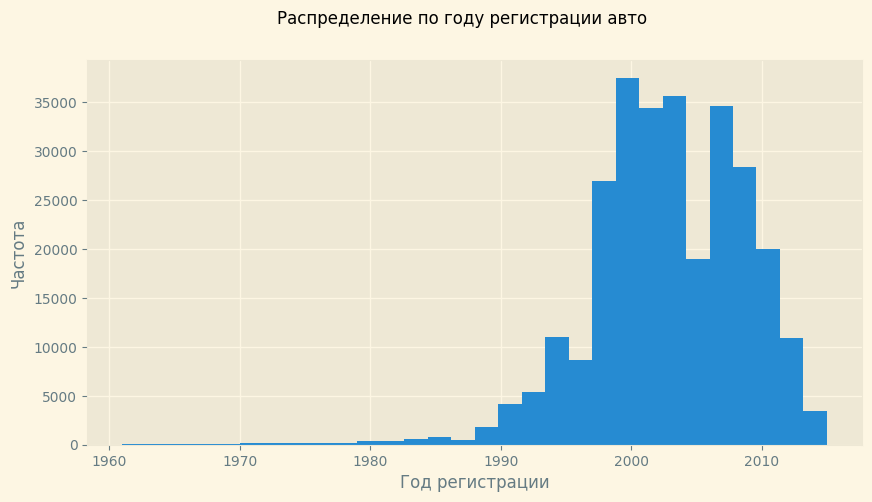

In [15]:
data = data[data['RegistrationYear'] < 2016]
fig, axes = plt.subplots(1,figsize=(10,5))
axes.hist(data['RegistrationYear'], bins=30)
fig.suptitle('Распределение по году регистрации авто')
axes.set_ylabel('Частота')
axes.set_xlabel('Год регистрации')
plt.show()

Теперь рассмотрим целевой признак — стоимость авто. Посмотрю на распределение и определю, есть ли тут аномалии.

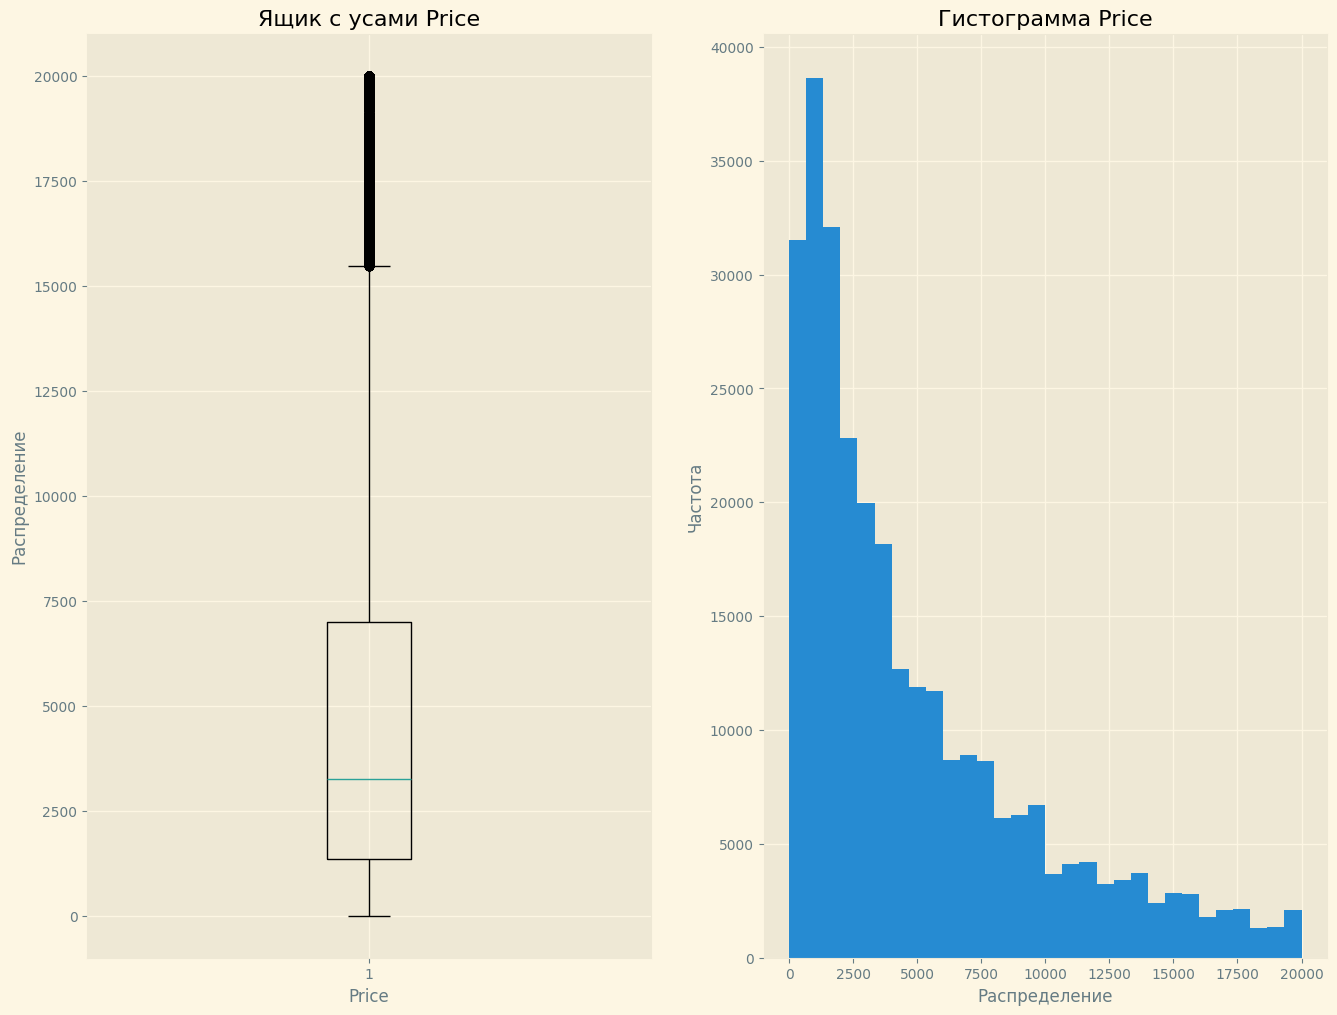

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
axes[0].boxplot(data['Price'])
axes[0].set_ylabel('Распределение')
axes[0].set_xlabel('Price')
axes[1].hist(data['Price'], bins=30)
axes[1].set_ylabel('Частота')
axes[1].set_xlabel('Распределение')
axes[0].set_title('Ящик с усами Price')
axes[1].set_title('Гистограмма Price')
plt.show()

По верхней границе есть определённое число выбросов, но по ним едва ли можно сказать, что они являются аномалиями: автомобили за 20,000 евро вполне существуют. Куда больше смущает, что нижний "ус" у boxplot-а упирается в 0. Бесплатные авто — это уже подозрительно, а потому удалю всё, что стоит меньше 10 евро.

In [17]:
data = data[data['Price'] >= 10]

### Влияние на целевой признак

Сперва стоит удалить признаки, которые по отпределению не оказывают влияния: дата выгрузки в БД, дата создания объявления, колличество изображений (потому что в этом столбце все значения равны 0), почтовый индекс владельца и его последнее посещение сайта.

In [18]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

С оставшимися построю матрицу phik, которая позволяет определить корреляцию между всеми признаками, категориальными или вещественными.

In [19]:
data.phik_matrix(interval_cols=['Price', 'Power'])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,1.000000,0.253902,0.677947,0.286208,0.504900,0.569139,0.334560,0.122597,0.255628,0.359948,0.333009
VehicleType,0.253902,1.000000,0.328924,0.379689,0.485566,0.903330,0.200002,0.180218,0.365105,0.592255,0.284684
RegistrationYear,0.677947,0.328924,1.000000,0.159405,0.258587,0.659101,0.644620,0.182651,0.354730,0.334345,0.303026
Gearbox,0.286208,0.379689,0.159405,1.000000,0.476569,0.623967,0.048424,0.161229,0.206556,0.509980,0.249751
Power,0.504900,0.485566,0.258587,0.476569,1.000000,0.789836,0.109164,0.047182,0.250749,0.574082,0.095866
Model,0.569139,0.903330,0.659101,0.623967,0.789836,1.000000,0.444777,0.188848,0.534085,0.997711,0.265991
Kilometer,0.334560,0.200002,0.644620,0.048424,0.109164,0.444777,1.000000,0.106176,0.167666,0.265453,0.186894
RegistrationMonth,0.122597,0.180218,0.182651,0.161229,0.047182,0.188848,0.106176,1.000000,0.192169,0.082935,0.311117
FuelType,0.255628,0.365105,0.354730,0.206556,0.250749,0.534085,0.167666,0.192169,1.000000,0.301250,0.188104
Brand,0.359948,0.592255,0.334345,0.509980,0.574082,0.997711,0.265453,0.082935,0.301250,1.000000,0.127211


Удалю те, корреляция которых меньше 0.3

In [20]:
data = data.drop(['RegistrationMonth', 'VehicleType', 'Gearbox', 'FuelType'], axis=1)
data.head(3)

,Price,RegistrationYear,Power,Model,Kilometer,Brand,Repaired
1,18300,2011,190,unknown,125000,audi,yes
2,9800,2004,163,grand,125000,jeep,unknown
3,1500,2001,75,golf,150000,volkswagen,no


Проверю, появились ли у нас новые явные дубликаты после удаления признаков.

In [21]:
data.duplicated().sum()

52795

Они действительно образовались, удаляю их.

In [22]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

### Выделение выборок

Выделяю целевой признак, а также разделяю выборки на тренировочную, тестовую и валидационную.

In [23]:
target = data['Price']
features = data.drop('Price', axis=1)

In [24]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target,
                                                                                        test_size=0.25,
                                                                                        random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid, target_train_valid,
                                                                              test_size=0.25,
                                                                              random_state=12345)

In [25]:
print('features_train shape:', features_train.shape)
print('features_valid shape:', features_valid.shape)
print('features_test shape:', features_test.shape)
print('target_train shape:', target_train.shape)
print('target_valid shape:', target_valid.shape)
print('target_test shape:', target_test.shape)

features_train shape: (127629, 6)
features_valid shape: (42543, 6)
features_test shape: (56725, 6)
target_train shape: (127629,)
target_valid shape: (42543,)
target_test shape: (56725,)


### Обработка категориальных переменных

Некоторые модели градиентного бустинга имеют встроенные обработчики категориальных переменных, но не все. Плюс, мне необходимо будет сравнить их результаты с не-бустинговыми моделями. Потому, обработаю категориальные переменные с использованием двух разных методов кодирования: OrdinalEncoder для древесных моделей и OneHotEncoder для линейной регрессии.

In [26]:
oh_encoder = OneHotEncoder(handle_unknown='ignore').fit(features_train)
features_train_ohe = oh_encoder.transform(features_train)
features_valid_ohe = oh_encoder.transform(features_valid)

In [27]:
cat = ['Model', 'Brand', 'Repaired']
o_encoder = OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value')
features_train[cat] = o_encoder.fit_transform(features_train[cat])
encoder = OrdinalEncoder()
features_valid[cat] = o_encoder.transform(features_valid[cat])
encoder = OrdinalEncoder()
features_test[cat] = o_encoder.transform(features_test[cat])
features_test.head(3)

,RegistrationYear,Power,Model,Kilometer,Brand,Repaired
177546,2015,75,74.0,20000,27.0,0.0
328,2002,150,169.0,150000,38.0,0.0
39251,2006,125,102.0,150000,10.0,0.0


Я закодировала категориальные переменные в виде чисел и теперь модели смогут их спокойно обрабатывать.



### Промежуточный вывод

В данном разделе я провела следующие работы:
- Загрузила данные из предоставленного датасета;
- Удалила явные дубликаты;
- Обработала пропущенные значения;
- Исключила аномалии;
- Выявила и удалили неинформативные для модели машинного обучения признаки;
- Выделила тренировочную, тестовую и валидационную выборки;
- Кодировала категорильные переменные, чтобы они могли быть обработаны моделями.

## Обучение моделей

В этом разделе я обучу три модели бустинга, а именно XGBoost, LightGBM и CatBoost, а также случайный лес и обычную линейную регрессию, чтобы в дальнейшем сравнить их все между собой.

### XGBoost

Данная библиотека бустинга позволяет использовать ансамбль как из деревьев решений, так и из линейной регресии, но поскольку деревья стоят по умолчанию, использую именно их.

In [28]:
%%time

best_model_xg = None
best_est = 0
best_depth = 0
best_rmse_xg = 100000

for est in [10, 50, 100]:
    for depth in [1, 5, 10]:

        model_xg = xg.XGBRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_xg.fit(features_train, target_train)
        pred = model_xg.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))

        if rmse < best_rmse_xg:
            best_rmse_xg = rmse
            best_model_xg = model_xg
            best_est = est
            best_depth = depth
print('RMSE лучшей модели XGBoost =', best_rmse_xg, 'с количеством деревьев', best_est, 'и максимальной глубиной', best_depth)

RMSE лучшей модели XGBoost = 1702.3487386728766 с количеством деревьев 100 и максимальной глубиной 10
CPU times: user 10.3 s, sys: 79.2 ms, total: 10.4 s
Wall time: 6.18 s


Запоминаем полученное RMSE, чтобы в дальнейшем сравнить с результатами других моделей.

### LightGBM

Ещё одна бустинговая модель — это LightGBM. Тоже работает с деревьями, и тоже поддерживает регрессию, что мне и нужно.

In [29]:
%%time

best_model_lgbm = None
best_est = 0
best_depth = 0
best_rmse_lgbm = 100000

for est in [10, 50, 100]:
    for depth in [1, 5, 10]:

        model_lgbm = lgbm.LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_lgbm.fit(features_train, target_train)
        pred = model_lgbm.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))
        if rmse < best_rmse_lgbm:
            best_rmse_lgbm = rmse
            best_model_lgbm = model_lgbm
            best_est = est
            best_depth = depth
print('RMSE лучшей модели LightGBM =', best_rmse_lgbm, 'с количеством деревьев', best_est, 'и максимальной глубиной', best_depth)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 127629, number of used features: 6
[LightGBM] [Info] Start training from score 5202.437730
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 127629, number of used features: 6
[LightGBM] [Info] Start training from score 5202.437730
[LightGBM] [Warning] Accuracy may be bad since you d

Результат стал чуть хуже, но при этом скорость выполнения ячейки куда выше.

### CatBoost

Для этой библиотеки бустинга необязательно было бы шифровать категориальные переменные, так как она делает это самостоятельно. Но я это всё равно сделала заранее для всех остальных моделей.

In [30]:
%%time

best_model_cb = None
best_est = 0
best_depth = 0
best_rmse_cb = 100000

for est in [10, 50, 100]:
    for depth in [1, 5, 10]:

        model_cb = cb.CatBoostRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_cb.fit(features_train, target_train)
        pred = model_cb.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))
        if rmse < best_rmse_cb:
            best_rmse_cb = rmse
            best_model_cb = model_cb
            best_est = est
            best_depth = depth
print('RMSE лучшей модели CatBoost =', best_rmse_cb, 'с количеством деревьев', best_est, 'и максимальной глубиной', best_depth)

Learning rate set to 0.5
0:	learn: 3972.3240631	total: 60.8ms	remaining: 548ms
1:	learn: 3621.2349046	total: 70.3ms	remaining: 281ms
2:	learn: 3323.9304047	total: 79.6ms	remaining: 186ms
3:	learn: 3128.3078124	total: 90.5ms	remaining: 136ms
4:	learn: 2975.6708442	total: 99.6ms	remaining: 99.6ms
5:	learn: 2881.6515596	total: 114ms	remaining: 75.7ms
6:	learn: 2809.8235438	total: 125ms	remaining: 53.7ms
7:	learn: 2762.4783772	total: 134ms	remaining: 33.5ms
8:	learn: 2711.1811508	total: 145ms	remaining: 16.1ms
9:	learn: 2672.6091480	total: 154ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3332.1115106	total: 18.3ms	remaining: 165ms
1:	learn: 2713.5743332	total: 36.8ms	remaining: 147ms
2:	learn: 2454.7813771	total: 62.6ms	remaining: 146ms
3:	learn: 2314.6169977	total: 80.9ms	remaining: 121ms
4:	learn: 2245.3740133	total: 96.3ms	remaining: 96.3ms
5:	learn: 2172.9107842	total: 111ms	remaining: 73.8ms
6:	learn: 2133.0195851	total: 125ms	remaining: 53.6ms
7:	learn: 2101.9328364	total: 145

CatBoost показал идентичную скорость, что и LightGBM, но при этом качество немного улучшилось.

### RandomForest

Добавим для сравнения с моделями бустинга беггинговую модель — случайный лес.

In [31]:
%%time

best_model_rf = None
best_est = 0
best_depth = 0
best_rmse_rf = 100000

for est in [10, 50, 100]:
    for depth in [1, 5, 10]:

        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        pred = model_rf.predict(features_valid)
        rmse = np.sqrt(mse(target_valid, pred))
        if rmse < best_rmse_rf:
            best_rmse_rf = rmse
            best_model_rf = model_rf
            best_est = est
            best_depth = depth
print('RMSE лучшей модели Случайный лес =', best_rmse_rf, 'с количеством деревьев', best_est, 'и максимальной глубиной', best_depth)

RMSE лучшей модели Случайный лес = 1952.2762952535677 с количеством деревьев 100 и максимальной глубиной 10
CPU times: user 46.6 s, sys: 67.4 ms, total: 46.7 s
Wall time: 46.8 s


Лес работал вдвое дольше предыдущих двух моделей и при этом дал RMSE хуже, чем градиентные бустинги.

### Linear reagression

Напоследок применю к нашим данным обыкновенную линейную регрессию. Вдруг все эти сложные ансамбли не имели особого смысла?

In [32]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)
pred = model_lr.predict(features_valid_ohe)
rmse_lr = np.sqrt(mse(target_valid, pred))
print('RMSE модели линейной регрессии =', rmse_lr)

RMSE модели линейной регрессии = 2065.404701003335
CPU times: user 2.81 s, sys: 2.24 s, total: 5.04 s
Wall time: 3.47 s


У линейной регрессии результат совсем плох в сравнении с ансамблями.

### Промежуточный вывод

Дольше всего выполнялся перебор гиперпараметров у случайного леса, среди бустингов — у XGBoost. По сравнению с ними, LightGBM и CatBoost сработали довольно быстро. По качеству, бустинг явно обходит беггинг и одиночную линейную регрессию.

## Анализ моделей

### Время обучения

Возьму модели с лучшими подобранными гиперпараметрами, обучу их и сравню время обучения.

In [33]:
%%time
best_model_xg.fit(features_train, target_train)

CPU times: user 3.14 s, sys: 98.4 ms, total: 3.24 s
Wall time: 1.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=12345, ...)

Обучение XGBoost у меня заняло 41 секунду.

In [34]:
%%time
best_model_lgbm.fit(features_train, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 127629, number of used features: 6
[LightGBM] [Info] Start training from score 5202.437730
CPU times: user 861 ms, sys: 5.94 ms, total: 867 ms
Wall time: 871 ms


LGBMRegressor(max_depth=10, random_state=12345)

LightGBM обучилась всего за 3 секунды.

In [35]:
%%time
best_model_cb.fit(features_train, target_train)

Learning rate set to 0.5
0:	learn: 3192.2717146	total: 32.8ms	remaining: 3.25s
1:	learn: 2516.5849594	total: 65.5ms	remaining: 3.21s
2:	learn: 2219.2898028	total: 97.4ms	remaining: 3.15s
3:	learn: 2076.4291736	total: 134ms	remaining: 3.22s
4:	learn: 2007.0944378	total: 166ms	remaining: 3.16s
5:	learn: 1970.3875319	total: 202ms	remaining: 3.16s
6:	learn: 1943.2716197	total: 233ms	remaining: 3.1s
7:	learn: 1913.6941940	total: 274ms	remaining: 3.15s
8:	learn: 1895.3916208	total: 309ms	remaining: 3.12s
9:	learn: 1878.6079461	total: 346ms	remaining: 3.11s
10:	learn: 1864.9321037	total: 379ms	remaining: 3.06s
11:	learn: 1857.5687837	total: 415ms	remaining: 3.04s
12:	learn: 1845.5166725	total: 453ms	remaining: 3.03s
13:	learn: 1836.6325126	total: 484ms	remaining: 2.97s
14:	learn: 1821.7665431	total: 529ms	remaining: 3s
15:	learn: 1814.8132361	total: 566ms	remaining: 2.97s
16:	learn: 1807.1354175	total: 597ms	remaining: 2.91s
17:	learn: 1801.5776964	total: 633ms	remaining: 2.88s
18:	learn: 179

Обучение CatBoost заняло 3,4 секунды, что не сильно больше.

In [36]:
%%time
best_model_rf.fit(features_train, target_train)

CPU times: user 17.2 s, sys: 28 ms, total: 17.2 s
Wall time: 17.7 s


RandomForestRegressor(max_depth=10, random_state=12345)

Случайный лес обучился за 11 секунд.

In [37]:
%%time
model_lr.fit(features_train, target_train)

CPU times: user 45.8 ms, sys: 3.95 ms, total: 49.7 ms
Wall time: 54.2 ms


LinearRegression()

Ну а линейная регрессия заняла всего 17 милисекунд.

Таким образом, быстрее всего обучилась линейная регрессия. Из бустингов LightGBM, сразу за ней CatBoost, затем случайный лес. Дольше всех училась XGBoost.

### Время предсказания

Теперь будем замерять время предсказания моделей. Вновь начнём с XGBoost.

In [38]:
%%time
pred_xg = best_model_xg.predict(features_valid)

CPU times: user 357 ms, sys: 24.5 ms, total: 382 ms
Wall time: 239 ms


XGBoost сделал предсказание за 0.2 секунды. Сравним с другими моделями.

In [39]:
%%time
pred_lgbm = best_model_lgbm.predict(features_valid)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: user 321 ms, sys: 861 µs, total: 322 ms
Wall time: 312 ms


LightGBM предсказывает за 0.3 секунды.

In [40]:
%%time
pred_cb = best_model_cb.predict(features_valid)

CPU times: user 39.1 ms, sys: 4 µs, total: 39.1 ms
Wall time: 24.9 ms


А CatBoost показывает какой-то совершенно нереальный результат по скорости предсказания, предсказывая всего за 0,02 секунды.

In [41]:
%%time
pred_rf = best_model_rf.predict(features_valid)

CPU times: user 458 ms, sys: 0 ns, total: 458 ms
Wall time: 460 ms


Случайный лес даёт результат чуть хуже, чем у LightGBM, предсказывая за 0,38 секунды.

In [42]:
%%time
pred_lr = model_lr.predict(features_valid)

CPU times: user 6.86 ms, sys: 996 µs, total: 7.86 ms
Wall time: 7.88 ms


Линейная регрессия же предсказывает быстрее всего, за 0,003 секунды

Таким образом, самое быстрое предсказание даёт Линейная регрессия с большим отрывом, на втором месте, также с отрывом находится CatBoost, далее XGBoost и LightGBM. Случайный лес показывает худший результат скорости.

### Оценка качества

По поставленной задаче, необходимо сравнить качество моделей метрикой RMSE, при этом метрика должна показывать не более 2500. Я уже считала её в пункте 2, выведу на экран от большей до меньшей.

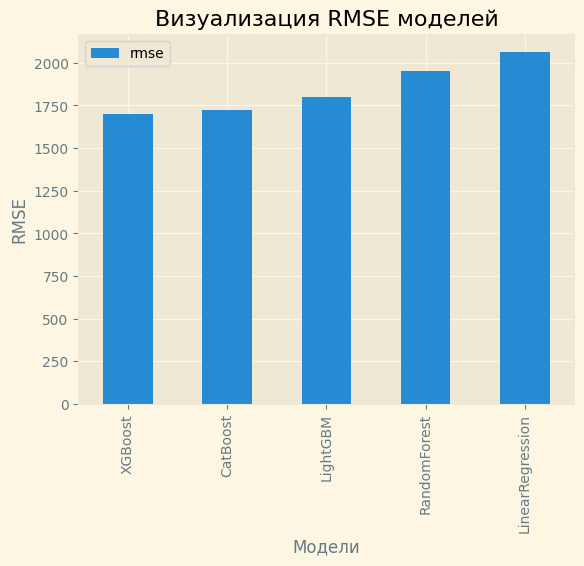

In [43]:
rmse = [best_rmse_xg, best_rmse_lgbm, best_rmse_cb, best_rmse_rf, rmse_lr]
ids = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'LinearRegression']
top_rmse = pd.DataFrame(data=rmse, index=ids, columns=['rmse'])
top_rmse.sort_values(by='rmse').plot.bar(title='Визуализация RMSE моделей', xlabel='Модели', ylabel='RMSE');

По графику выше наглядно видно, что самым высоким, показателем RMSE обладает линейная регрессия. Ансамбли же все показали достойный результат. Самый лучший показатель у XGBoost, на втором месте с небольшой разницей CatBoost, далее LightGBM и случайный лес.

### Промежуточный вывод

По скорости обучения, среди бустингов самой быстрой оказалась LightGBM, сразу за ней CatBoost, последняя — XGBoost. По скорости предсказания, с огромным отрывом впереди находится CatBoost, на втором месте, в почти десять раз медленнее предсказывает XGBoost, за ней LightGBM. По качеству предсказания, лучший результат  XGBoost, на втором месте CatBoost, на третьем — LightGBM.

Принимая во внимание, что модель подбирается для работы на онлайн-сервисе для продажи автомобилей, можно сказать, что скорость предсказания является более важным критерием, чем скорость обучения, поскольку пользователь должен получать ответ на свой запрос максимально быстро. Таким образом, CatBoost должен подойти под задачу заказчика: у него хорошее качество обучения, приемлемая скорость обучения и необычайно высокая скорость предсказания.

## Проверка модели

Я выбрала модель CatBoost за высокую скорость предсказания. Проверю её качество на тестовой выборке.

In [44]:
%%time
pred_test = best_model_cb.predict(features_test)
rmse_test = np.sqrt(mse(target_test, pred_test))
print('На тестовой выборке CatBoost показывает RMSE', rmse_test)

На тестовой выборке CatBoost показывает RMSE 1715.8076422500671
CPU times: user 53.7 ms, sys: 13.9 ms, total: 67.6 ms
Wall time: 47.1 ms


CatBoost дал нам и приемлемое качество и высокую скорость предсказания. Но что если её результат не сильно отличается от константной модели? Обучу модель, которая будет предсказывать среднее значение, и посчитаю её RMSE.

In [45]:
%%time
model_dr = DummyRegressor(strategy='mean')
model_dr.fit(features_test, target_test)
pred_dr = model_dr.predict(features_test)
rmse_dr = np.sqrt(mse(target_test, pred_dr))
print('Константная модель показывает RMSE', rmse_dr, 'Это больше RMSE CatBoost на', rmse_dr - rmse_test)

Константная модель показывает RMSE 4697.968943132681 Это больше RMSE CatBoost на 2982.1613008826134
CPU times: user 3.74 ms, sys: 987 µs, total: 4.72 ms
Wall time: 4.8 ms


Как видно, разница между CatBoost и константой почти 3 тысячи. Это показывает, что градиентный бустинг в нашем случае обучился очень эффективно, без переобучения.

## Вывод

Задачей данного проекта было построить модель, умеющую определять стоимость автомобиля в евро по её характеристикам.

Для этого мною были произведены следующие работы:
- Обработаны дубликаты, пропущенные значения и аномалии;
- Определено влияние признаков на целевой признак и удалены незначительные признаки;
- Выделены обучающая, валидационная и тестовая выборки;
- Обработаны категориальные признаки;
- Обучены пять моделей: три градиентного бустинга, случайный лес и линейная регрессия, с перебором гиперпараметров;
- Проанализированы все модели по характеристикам, важным для заказчика: скорости обучения и предсказания, качеству по метрике RMSE;
- Выбрана и протестирована лучшая модель.

В результате, мною была выбрана модель градиентного бустинга из библиотеки CatBoost от Яндекса, поскольку она показывает хорошие скорость обучения и качество предсказания при высочайшей скорости предсказания.